# Alt-chain temporal study
## Monero Archival Project

IsthmusCrypto 2018.07

Here, alt-chain ("block1") data is compared against main-chain.

Specifically, we note patterns in times between subsequent blocks.

Objectives:
-  What does the timing suggest regarding alternate chains
-  If consistent timing within a given side chain, estimate hashpower
-  If consistent timing across side chains, suggests single player
-  Check to see if the hashpower sunk into side chains disappears from main chain

## Import libraries

In [1]:
import pandas as pd
from copy import copy
import datetime
import numpy as np
import matplotlib.pyplot as plt
import time

## Where are files saved?

In [2]:
block0s_relative_path = 'altchain_logs/block0s.txt'
block1s_relative_path = 'altchain_logs/block1s.txt'

## Import files

In [3]:
b0s_raw = pd.read_csv(block0s_relative_path)
b1s_raw = pd.read_csv(block1s_relative_path)

# Modify this version:
b0s = copy(b0s_raw)
b1s = copy(b1s_raw)

b0s = b0s.sort_values('block_height')
b1s = b1s.sort_values('block_height')

pass

### Sneak a peek at the data

Typically, see duplicates.

b0, or b1. Here, b1

In [4]:
print(type(b1s_raw))
b1s_raw[0:20]

<class 'pandas.core.frame.DataFrame'>


,block_time,block_height,block_nonce,block_random
0,1522901487,1545098,2684357998,11314
1,1522901487,1545098,2684357998,11935
2,1522901487,1545098,2684357998,14423
3,1522901487,1545098,2684357998,16546
4,1522901487,1545098,2684357998,16865
5,1522901487,1545098,2684357998,17566
6,1522901487,1545098,2684357998,19975
7,1522901487,1545098,2684357998,24988
8,1522901487,1545098,2684357998,27186
9,1522901487,1545098,2684357998,27796


## De-duplicate

In [5]:
b0s.drop(['block_random'],1,inplace=True)
b0s=b0s.drop_duplicates()

b1s.drop(['block_random'],1,inplace=True)
b1s=b1s.drop_duplicates()
b1s[0:20]

,block_time,block_height,block_nonce
0,1522901487,1545098,2684357998
439,1523003051,1546000,570430823
648,1523337099,1547963,2139397
654,1525032170,1562061,3579158795
655,1525032261,1562062,2970728396
660,1525219207,1563626,668103
666,1525470502,1565690,589661
667,1525470534,1565691,358009781
678,1525470959,1565692,2863312291
679,1525472810,1565693,1073825901


## Generate differenece coulmns

In [6]:
b0s['delta_height'] = b0s['block_height']-b0s['block_height'].shift()
b0s['delta_time'] = b0s['block_time']-b0s['block_time'].shift()

b1s['delta_height'] = b1s['block_height']-b1s['block_height'].shift()
b1s['delta_time'] = b1s['block_time']-b1s['block_time'].shift()

## Drop rows with jumps (delta_height > 1)

In [7]:
b0s = b0s[b0s.delta_height == 1]
b1s = b1s[b1s.delta_height == 1]

## What are we left with?

In [8]:
print('Retained ' + str(len(b0s)) + ' main-chain blocks')
print('Retained ' + str(len(b1s)) + ' side-chain blocks')

Retained 17914 main-chain blocks
Retained 190 side-chain blocks


## Study block times

In [9]:
b0_mean_time_s = np.mean(b0s.delta_time)
b1_mean_time_s = np.mean(b1s.delta_time)

print('Main-chain blocks come with mean time: ' + str(round(b0_mean_time_s)) + ' seconds = ' + str(round(b0_mean_time_s/60,1)) + ' min')
print('Side-chain blocks come with mean time: ' + str(round(b1_mean_time_s)) + ' seconds = ' + str(round(b1_mean_time_s/60,1)) + ' min')

Main-chain blocks come with mean time: 120 seconds = 2.0 min
Side-chain blocks come with mean time: 6254 seconds = 104.2 min


### Visualize In terms of seconds

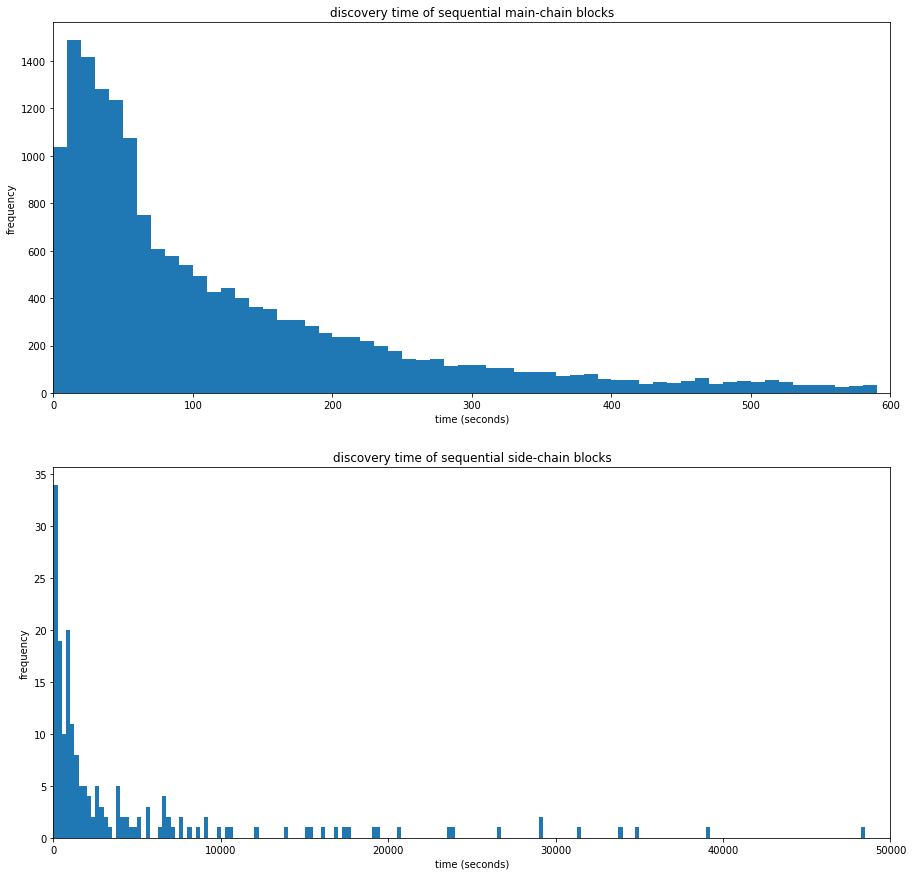

In [10]:
fig = plt.figure(figsize=(15,15))
ax1 = fig.add_subplot(211)
ax1.set_xlabel('time (seconds)')
ax1.set_ylabel('frequency')
ax1.set_title('discovery time of sequential main-chain blocks')
plt.hist(b0s.delta_time, bins=range(0,600,10))
ax1.set_xlim((0,600))
ax2 = fig.add_subplot(212)
plt.hist(b1s.delta_time, bins=range(0,50000,250))
ax2.set_xlabel('time (seconds)')
ax2.set_ylabel('frequency')
ax2.set_title('discovery time of sequential side-chain blocks')
ax2.set_xlim((0,50000))
pass

## Temporal feature engineering

Comparing temporal patterns among different side chains

### Initialization

In [11]:
b1s['side_chain_ID'] = 0
b1s['terminal_block']= 0 # is this the last block in the side-chain?
b1s['side_chain_length'] = b1s['block_height']-b1s['block_height'].shift() # how long did this side-chain get?
b1s['side_chain_time'] = 0

b1s = b1s.reset_index()
b1s.drop(['index','delta_height'], 1, inplace=True)
b1s.side_chain_length[0] = 0 # since we don't know what preceded
b1s.head()

/home/m/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,block_time,block_height,block_nonce,delta_time,side_chain_ID,terminal_block,side_chain_length,side_chain_time
0,1525032261,1562062,2970728396,91.0,0,0,0.0,0
1,1525470534,1565691,358009781,32.0,0,0,3629.0,0
2,1525470959,1565692,2863312291,425.0,0,0,1.0,0
3,1525472810,1565693,1073825901,1851.0,0,0,1.0,0
4,1525473108,1565694,20355,298.0,0,0,1.0,0


### Actually calculate the new features

In [12]:
side_chain_counter = 0
for index, row in b1s.iterrows():
    
    this_row_val = b1s.side_chain_length[index]
    
    # print('index: ' + str(index) + ' this_row_val: ' + str(this_row_val))
    
    # Mark how far down this chain we've gotten
    if this_row_val > 1:
        # first block in the side-chain
        b1s.side_chain_length[index] = 1
        b1s.terminal_block[index-1] = 1
        side_chain_counter = side_chain_counter + 1 # increment the counter
        b1s.side_chain_ID[index] = side_chain_counter # mark the counter
    else:
        # subsequent block
        if index > 0:
            b1s.side_chain_length[index] = b1s.side_chain_length[index-1]+1
            delta_t_seconds = b1s.block_time[index] - b1s.block_time[index-1]
            b1s.side_chain_time[index] = b1s.side_chain_time[index-1] + delta_t_seconds
            b1s.side_chain_ID[index] = side_chain_counter

/home/m/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/home/m/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
/home/m/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/m/anaconda3/lib/python3.6/site-packages/ipykernel_l

### Check out our new perspective

Let's look at 24 of the peculiar long side chains

For each side chain, I mark a point for each block indicating the length of the chain in both blocks (x-axis) and time (y-axis)

This fingerprints the producers of side chains by their hash power (slope of the line proportional to that entity's hash rate)

The red line shows 2-minutes per block, so any entity producing blocks near that speed can feasibly overtake the main chain. The further a side chain is from the red line, the more exponentially improbable it becomes.

Let's take a look at the first 20 blocks:

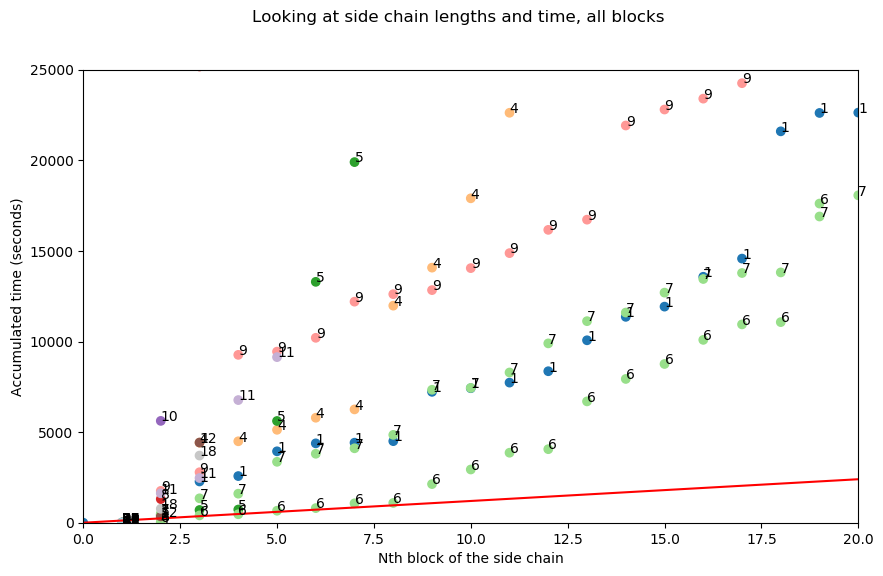

In [13]:
max_chain_length = 20
max_chain_time = 25000

norm_block_time = 120 # seconds

fig = plt.figure(figsize=(10,6), dpi=100)
plt.scatter(b1s.side_chain_length, b1s.side_chain_time+1, c=b1s.side_chain_ID, cmap='tab20')
fig.suptitle('Looking at side chain lengths and time, all blocks')
plt.xlabel('Nth block of the side chain')
plt.ylabel('Accumulated time (seconds)')
plt.xlim((0,max_chain_length))
plt.ylim((0,max_chain_time))

for i, txt in enumerate(b1s.side_chain_ID):
    # print(i)
    X = b1s.side_chain_length[i]
    Y = b1s.side_chain_time[i]
    S = b1s.side_chain_ID[i]
    # print("X = " + str(X), " // Y = " + str(Y) + " // S = " + str(S))
    if i > 0 and X <= max_chain_length and Y <= max_chain_time:
        plt.text(X,Y,S)
        
# Add on a regular rate
plt.plot((0,max_chain_length), (0, max_chain_length*norm_block_time), c='red')

Wow, definitely a few players causing many of the side chains... {#1, #6(?), #7} and {#4, #9}



Entity with side chain #6 may have pulled off successful 51% attacks already. 

Who could have that much hash power? And these are all since July when we were supposedly rid of ASICs.... 

... By the way one of the chains was 70 blocks long! 

*(zooming out on the previous plot)*

(-3.4542580645161296,
 72.454258064516139,
 -47940.907284768218,
 1006780.9072847682)

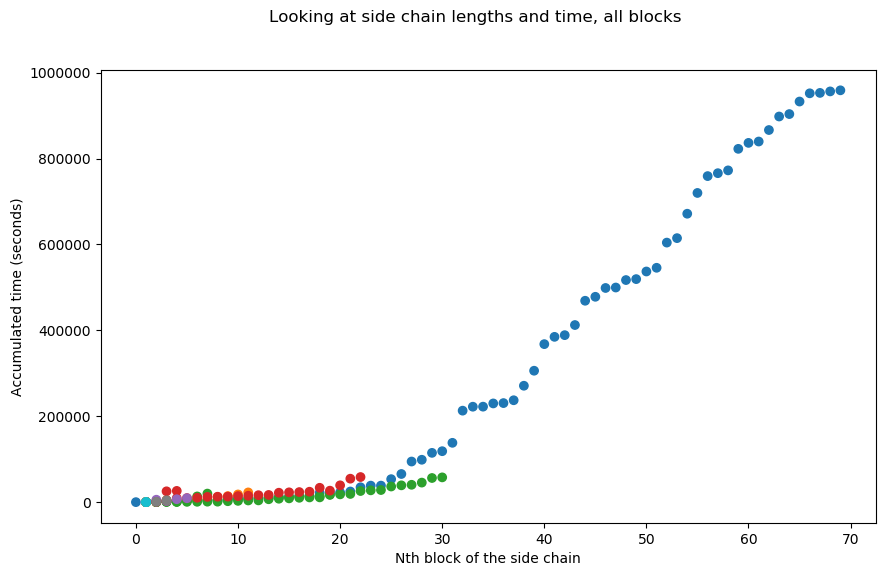

In [14]:
fig = plt.figure(figsize=(10,6), dpi=100)
plt.scatter(b1s.side_chain_length, b1s.side_chain_time+1, c=b1s.side_chain_ID, cmap='tab10')
fig.suptitle('Looking at side chain lengths and time, all blocks')
plt.xlabel('Nth block of the side chain')
plt.ylabel('Accumulated time (seconds)')
plt.axis('tight')

## How long do these side chains persist?

Text(0.5,1,'How long are the side chains (time)')

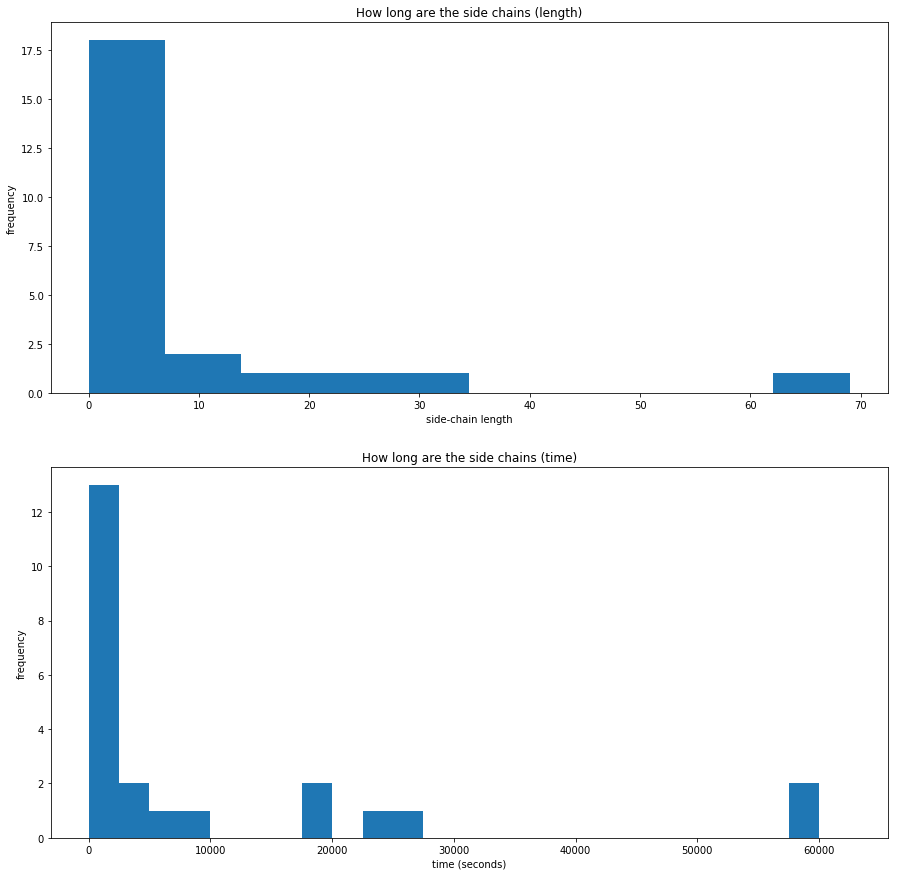

In [15]:
fig = plt.figure(figsize=(15,15))
ax1 = fig.add_subplot(211)
ax1.set_xlabel('side-chain length')
ax1.set_ylabel('frequency')
ax1.set_title('How long are the side chains (length)')
plt.hist(b1s.side_chain_length[b1s.terminal_block==1])

ax2 = fig.add_subplot(212)
plt.hist(b1s.side_chain_time[b1s.terminal_block==1],bins=range(0,65000,2500))
ax2.set_xlabel('time (seconds)')
ax2.set_ylabel('frequency')
ax2.set_title('How long are the side chains (time)')

## Let's manually check out whether the network lost hash power during {#1, #6, and #7}

In [19]:
for i, x in enumerate(b1s.side_chain_ID.unique()):
    #print('Side chain #' + str(i) + ' median time: ', + np.median(b1s.block_time[b1s.side_chain_ID==i]))
    print('Side chain #' + str(i) + ' median time: ' + time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(np.median(b1s.block_time[b1s.side_chain_ID==i]))))
    print('\t... started at height ' + str(min(b1s.block_height[b1s.side_chain_ID==i])) + '\n')

Side chain #0 median time: 2018-04-29 15:04:21
	... started at height 1562062

Side chain #1 median time: 2018-05-07 08:38:58
	... started at height 1565691

Side chain #2 median time: 2018-05-05 20:01:52
	... started at height 1566501

Side chain #3 median time: 2018-05-06 10:09:31
	... started at height 1566909

Side chain #4 median time: 2018-05-08 18:28:32
	... started at height 1568537

Side chain #5 median time: 2018-05-17 01:15:15
	... started at height 1574527

Side chain #6 median time: 2018-05-23 03:01:54
	... started at height 1578848

Side chain #7 median time: 2018-05-25 03:19:34
	... started at height 1580197

Side chain #8 median time: 2018-05-27 11:06:31
	... started at height 1581882

Side chain #9 median time: 2018-05-29 09:40:02
	... started at height 1583267

Side chain #10 median time: 2018-05-30 22:37:53
	... started at height 1584465

Side chain #11 median time: 2018-06-03 21:17:59
	... started at height 1587294

Side chain #12 median time: 2018-06-07 11:28:04
	.